In [54]:
from tda.experiments.visualization.kernel_pca_binary import *
from tda.embeddings import EmbeddingType, KernelType
from tda.models.architectures import mnist_mlp, mnist_lenet, svhn_lenet
from tda.logging import get_logger

In [55]:
config = Config(
    embedding_type=EmbeddingType.PersistentDiagram,
    kernel_type=KernelType.SlicedWasserstein,
    thresholds='0.4_0.03_0.4_0.03_0_0_0',
    epochs=200,
    dataset="SVHN",
    architecture=svhn_lenet.name,
    train_noise=0.0,
    dataset_size=2,
    successful_adv=1,
    attack_type="All",
    identical_train_samples=1,
    noise=0.0,
    
    num_iter=1,
    height=1,
    hash_size=1,
    node_labels=0,
    steps=1
)

#### Get embeddings

In [56]:
clean_embeddings, noisy_embeddings, adv_embeddings, adv_embeddings_all, \
thresholds, all_noises, all_epsilons = get_all_embeddings(config)

2020-01-20 23:03:51,083 - Models - INFO - Filename = /Users/m.goibert/Documents/Criteo/P2_TDA_Detection/TDA_for_adv_robustness/tda/../trained_models/svhn_svhn_lenet_200_epochs.model 

/Users/m.goibert/Documents/Criteo/P2_TDA_Detection/TDA_for_adv_robustness/tda_env/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'tda.models.architectures.Architecture' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
2020-01-20 23:03:51,121 - Models - INFO - Loaded successfully model from /Users/m.goibert/Documents/Criteo/P2_TDA_Detection/TDA_for_adv_robustness/tda/../trained_models/svhn_svhn_lenet_200_epochs.model
2020-01-20 23:03:51,127 - Thresholds - INFO - Detected legacy format for thresholds
2020-01-20 23:03:51,131 - Thresholds - INFO - My received thresholds {(-1, 0): 

2020-01-20 23:05:07,899 - GraphDataset - INFO - Checking that the received architecture has been trained
2020-01-20 23:05:07,900 - GraphDataset - INFO - OK ! Architecture is ready
2020-01-20 23:05:07,901 - GraphDataset - INFO - I am going to generate a dataset of 2 points...
2020-01-20 23:05:07,902 - GraphDataset - INFO - Only successful adversaries ? yes
2020-01-20 23:05:07,903 - GraphDataset - INFO - Which attack ? BIM
2020-01-20 23:05:07,910 - GraphDataset - INFO - We are going to use a saved dataset: adv_test_BIM_eps=0.025_50ex.pt (dataset size required = 2)
2020-01-20 23:05:18,315 - Visualization PCA - INFO - Computed embeddings for (attack = All, eps=0.025, noise=0.0), number of sample = 2
2020-01-20 23:05:18,315 - Visualization PCA - INFO - Attack type = BIM and epsilon = 0.05
2020-01-20 23:05:18,316 - GraphDataset - INFO - Using source dataset svhn
2020-01-20 23:05:18,316 - GraphDataset - INFO - Checking that the received architecture has been trained
2020-01-20 23:05:18,317 - 

Add some parameters (for kernel)

In [57]:
logger.info(f"Using kernel {config.kernel_type} with embeddings {config.embedding_type}")

if config.kernel_type == KernelType.RBF:
    param_space = [
        {'gamma': gamma}
        for gamma in np.logspace(-6, -3, 10)
    ]
elif config.kernel_type == KernelType.SlicedWasserstein:
    param_space = [
        {'M': 20, 'sigma': 5 * 10 ** (-1)},
    ]
else:
    raise NotImplementedError(f"Unknown kernel {config.kernel_type}")

2020-01-20 23:07:17,431 - Visualization PCA - INFO - Using kernel SlicedWasserstein with embeddings PersistentDiagram


In [58]:
embedding_init = clean_embeddings + noisy_embeddings + adv_embeddings_all
for param in param_space:
    gram_matrix = get_gram_matrix(
    kernel_type=config.kernel_type,
    embeddings_in=embedding_init,
    embeddings_out=None,
    params=param
    )
kpca = KernelPCA(2, kernel="precomputed")
transform_input = kpca.fit_transform(gram_matrix)

/Users/m.goibert/Documents/Criteo/P2_TDA_Detection/TDA_for_adv_robustness/tda/embeddings/persistent_diagrams.py:67: RuntimeWarning: invalid value encountered in subtract
  val = np.nan_to_num(np.asarray(v1) - np.asarray(v2))


KeyboardInterrupt: 

### Plotting

In [49]:
binary_path = os.path.dirname(os.path.abspath(''))
binary_path_split = pathlib.Path(binary_path)
directory = str(pathlib.Path(*binary_path_split.parts[:-1])) + "/tda/plots/visualization/kernel_pca/" + str(config.architecture)
if not os.path.exists(directory):
    os.makedirs(directory)
filename = directory + f"/{config.attack_type}.png"
plt.style.use('seaborn-dark')

In [51]:
labels = len(clean_embeddings)*list(["Clean"]) #+ len(noisy_embeddings)*list(["Noisy"])
for noise in all_noises:
    labels += (len(noisy_embeddings)//len(all_noises))*list([f"Noisy {noise}"])
if config.attack_type != "All":
    for epsilon in all_epsilons:
        labels += len(adv_embeddings[epsilon])*list([f"Adv {config.attack_type} {epsilon}"])
else:
    for att in ["FGSM", "BIM", "DeepFool", "CW"]:
        if att in ["FGSM", "BIM"]:
            for epsilon in all_epsilons:
                labels += len(adv_embeddings[att][epsilon])*list([f"Adv {att} {epsilon}"])
        else:
            labels += len(adv_embeddings[att][1])*list([f"Adv {att} {1}"])
logger.info(f"Labels = {labels}")

2020-01-20 22:43:00,434 - Visualization PCA - INFO - Labels = ['Clean', 'Clean', 'Noisy 0.025', 'Noisy 0.025', 'Noisy 0.05', 'Noisy 0.05', 'Noisy 0.1', 'Noisy 0.1', 'Adv FGSM 0.025', 'Adv FGSM 0.025', 'Adv FGSM 0.05', 'Adv FGSM 0.05', 'Adv FGSM 0.1', 'Adv FGSM 0.1']


In [52]:
le = len(all_epsilons)
if config.attack_type == "FGSM":
    pal = sns.color_palette(["#0F0F0F", "#C9C9C9", "#A0A0A0", "#757575"] + sns.color_palette("Blues", le))
elif config.attack_type == "BIM":
    pal = sns.color_palette(["#0F0F0F", "#A0A0A0"] + sns.color_palette("Greens", le))
elif config.attack_type == "DeepFool":
    pal = sns.color_palette(["#0F0F0F", "#A0A0A0", "#FEB307"])
elif config.attack_type == "CW":
    pal = sns.color_palette(["#0F0F0F", "#A0A0A0", "#C50000"])
else:
    pal = sns.color_palette(["#0F0F0F", "#A0A0A0"] + sns.color_palette("Blues", le) + sns.color_palette("Greens", le) + ["#FEB307"] + ["#C50000"])

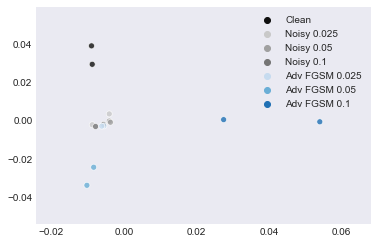

2020-01-20 22:44:05,563 - Visualization PCA - INFO - Closing figure


In [53]:
p = sns.scatterplot(x=[500*item[0] for item in transform_input], y=[500*item[1] for item in transform_input],
    hue=labels, palette=pal, alpha=0.8)
#plt.savefig(filename, dpi=600)
#plt.clf()
plt.show()
logger.info(f"Closing figure")

In [ ]:
if config.attack_type == "All":
    for att in ["FGSM", "BIM", "DeepFool", "CW"]:
        clean_noisy_end = 2*config.dataset_size
        labels2 = len(clean_embeddings)*list(["Clean"]) + len(noisy_embeddings)*list(["Noisy"])
        filename2 = directory + f"/{config.attack_type}_viz_{att}.png"
        if att == "FGSM":
            fgsm_end = clean_noisy_end + len(adv_embeddings[att])*config.dataset_size
            other_transform_input = transform_input[0:fgsm_end]
            pal2 = sns.color_palette(["#0F0F0F", "#A0A0A0"] + sns.color_palette("Blues", le))
            for epsilon in all_epsilons:
                labels2 += len(adv_embeddings[att][epsilon])*list([f"Adv {att} {epsilon}"])
        elif att == "BIM":
            bim_end = fgsm_end + len(adv_embeddings[att])*config.dataset_size
            other_transform_input = list(transform_input[:clean_noisy_end]) + list(transform_input[fgsm_end:bim_end])
            pal2 = sns.color_palette(["#0F0F0F", "#A0A0A0"] + sns.color_palette("Greens", le))
            for epsilon in all_epsilons:
                labels2 += len(adv_embeddings[att][epsilon])*list([f"Adv {att} {epsilon}"])
        elif att == "DeepFool":
            deepfool_end = bim_end + len(adv_embeddings[att])*config.dataset_size
            other_transform_input = list(transform_input[:clean_noisy_end]) + list(transform_input[bim_end:deepfool_end])
            pal2 = sns.color_palette(["#0F0F0F", "#A0A0A0", "#FEB307"])
            labels2 += len(adv_embeddings[att][1])*list([f"Adv {att} {1}"])
        elif att == "CW":
            other_transform_input = list(transform_input[:clean_noisy_end]) + list(transform_input[deepfool_end:])
            pal2 = sns.color_palette(["#0F0F0F", "#A0A0A0", "#C50000"])
            labels2 += len(adv_embeddings[att][1])*list([f"Adv {att} {1}"])
        p2 = sns.scatterplot(x=[item[0] for item in other_transform_input], y=[item[1] for item in other_transform_input],
            hue=labels2, palette=pal2, alpha=0.8)
        #plt.savefig(filename2, dpi=600)
        #plt.clf()
        plt.show()
        logger.info(f"Closing figure")